<a href="https://colab.research.google.com/github/garodisk/Amazon-4-million-reviews-sentiment-analusys/blob/master/Amazon_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Amazon reviews for sentiment Analysis** ( **Deep Learning Approach** )

Ecommerce companies like Amazon, Walmart, Kroger, etc have a lot of customer review data which they can leverage to make better recommendations, analyze products and sellers and a lot of more stuffs. Fortunately, machine learning and **deep learning** come to the resue in order to make state of the art sentiment predictions on the reviews. The review data is ofcourse unstructured which can be modelled using different techniques.

Here's a deep learning approach that I am gonna use to classify the sentiments of all the Amazon reviews as positive or a negative sentiment. The dataset has about **4 million reviews** and has been taken from kaggle.

https://www.kaggle.com/bittlingmayer/amazonreviews

Lets start our analysis.


In [0]:
#mounting drive to download data using kaggle API

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saketgarodia1","key":"c9d81a17bfe47308e791885989ee4844"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [0]:
!kaggle datasets list -s amazon

ref                                                        title                                               size  lastUpdated          downloadCount  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
snap/amazon-fine-food-reviews                              Amazon Fine Food Reviews                           242MB  2017-05-01 18:51:31          61089  
sid321axn/amazon-alexa-reviews                             Amazon Alexa Reviews                               164KB  2018-07-31 17:45:14           6805  
bittlingmayer/amazonreviews                                Amazon Reviews for Sentiment Analysis              493MB  2019-11-18 02:50:34          20221  
grikomsn/amazon-cell-phones-reviews                        Amazon Cell Phones Reviews                           9MB  2019-12-26 22:21:16           5446  
datafiniti/consumer-reviews-of-amazon-products             Consumer Reviews 

In [0]:
#downloading dataset

!kaggle datasets download -d bittlingmayer/amazonreviews  -p /content/gdrive/My\ Drive/kaggle --force

 99% 489M/493M [00:08<00:00, 65.6MB/s]
100% 493M/493M [00:08<00:00, 58.8MB/s]


In [0]:
!ls "/content/gdrive/My Drive/kaggle"


amazonreviews.zip  test.ft.txt.bz2  train.ft.txt.bz2  Training.zip
Test		   Test.zip	    Training


In [0]:
#unzipping amazon reviews folder

!unzip -uq "/content/gdrive/My Drive/kaggle/amazonreviews.zip" -d "/content/gdrive/My Drive/kaggle"

In [0]:
!ls "/content/gdrive/My Drive/kaggle"


amazonreviews.zip  test.ft.txt.bz2  train.ft.txt.bz2  Training.zip
Test		   Test.zip	    Training


Now that we have unzipped our folder, lets start the analysis. Lets first import all the necessary libraries.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

%matplotlib inline

Lets now load train and test data into separate files of train reviews, test reviews and their labels.

In [0]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('/content/gdrive/My Drive/kaggle/train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('/content/gdrive/My Drive/kaggle/test.ft.txt.bz2')

In [0]:
len(train_labels)

#4 million reviews on training data, thats a lot

3600000

In [0]:
import nltk

In [0]:
len(train_texts)

3600000

Before performing any pre-processing, lets have a overview of popular words in the training data for positive and negative sentiments.

In [0]:
#dataframe of training data

df_all = pd.DataFrame({'train_data' : train_texts, 'train_sentiment' : train_labels})

In [0]:
df_all.head()

,train_data,train_sentiment
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [0]:
#making positive and negative sentiments separate dataframes

df_positive = df_all[df_all['train_sentiment'] == 1]
df_negative = df_all[df_all['train_sentiment'] == 0]

In [0]:
df_positive.head()

,train_data,train_sentiment
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [0]:
df_negative.head()

,train_data,train_sentiment
6,"Buyer beware: This is a self-published book, a...",0
10,The Worst!: A complete waste of time. Typograp...,0
13,Oh please: I guess you have to be a romance no...,0
14,Awful beyond belief!: I feel I have to write t...,0
15,Don't try to fool us with fake reviews.: It's ...,0


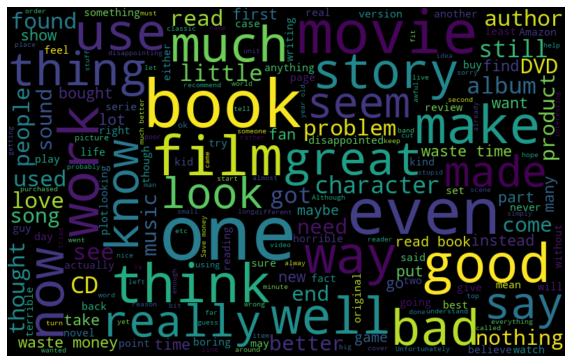

In [0]:
#visualizing wordcloud for negative reviews.
from wordcloud import WordCloud
all_words = ''.join([word for word in df_negative['train_data'][0:100000]])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

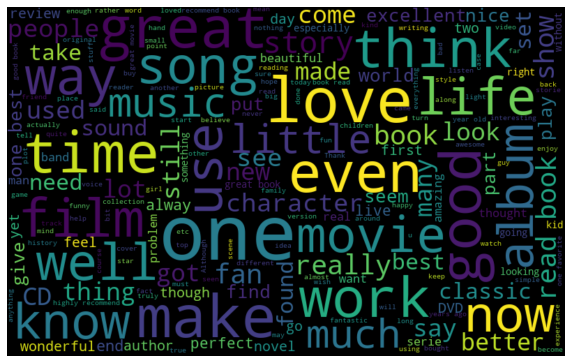

In [0]:
#building wordcloud for positive reviews.
from wordcloud import WordCloud
all_words = ''.join([word for word in df_positive['train_data'][0:100000]])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Now, lets do some preprocessing stuffs like making every word in lowercase format, removing non-alphanumeric characters and non ascii words.

In [0]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

Now, let us remove the stopwords.

In [0]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
def filter_stop_words(train_texts, stop_words):
    for i, sentence in enumerate(train_texts):
        new_sent = [word for word in sentence.split() if word not in stop_words]
        train_texts[i] = ' '.join(new_sent)
    return train_texts

stop_words = set(stopwords.words("english"))
train_texts = filter_stop_words(train_texts, stop_words)

Now, we will limit out max features  ( or number of words to 12000 ) as we have a lot of data. Even 12000 words should give pretty much decent analysis. We will use Keras Tokenizer function which s very easy to perform all these feature selection according to frequency and many other stuffs.

In [0]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)

Now, lets visualize once more after the preprocessing. After removing useless words, the workcloud will seem more logical.

In [0]:
df_all = pd.DataFrame({'train_data' : train_texts, 'train_sentiment' : train_labels})
df_positive = df_all[df_all['train_sentiment'] == 1]
df_negative = df_all[df_all['train_sentiment'] == 0]

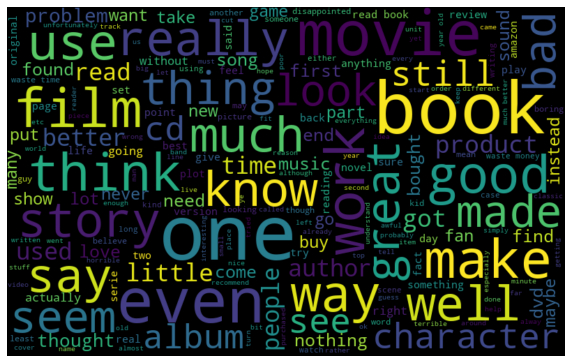

In [0]:
#building wordcloud after lemmatization
from wordcloud import WordCloud
all_words = ''.join([word for word in df_negative['train_data'][0:100000]])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

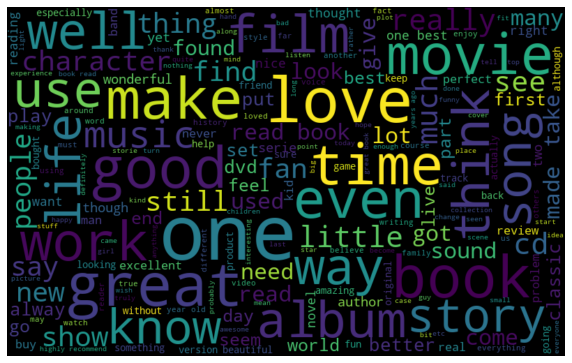

In [0]:
#building wordcloud after lemmatization
from wordcloud import WordCloud
all_words = ''.join([word for word in df_positive['train_data'][0:100000]])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Now, let us create a separate training and test set and let uss fit the tokenizer we created above to transform the text to sequence of numbers which can be fed into models.

In [0]:
#splitting data.

from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, random_state=43, test_size=0.2)

In [0]:
#transforming text data into number form
train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)

Now, we will use pad_sequences to make the length of each sentence same .

In [0]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

In [0]:
#maximum length of a review

MAX_LENGTH

155

In [0]:
train_texts.shape

(2880000, 155)

In [0]:
train_texts

array([[   0,    0,    0, ...,   11,    4, 1088],
       [   0,    0,    0, ..., 1103,   31, 8573],
       [   0,    0,    0, ...,  394, 2612,   77],
       ...,
       [   0,    0,    0, ..., 2785,    4,   18],
       [   0,    0,    0, ...,  196, 1509,  696],
       [   0,    0,    0, ...,  721,  505,  148]], dtype=int32)

Each of the 288,0000 reviews have 155 words

In [0]:
from keras.optimizers import SGD, Adam, RMSprop


Using TensorFlow backend.


Now we will create our model, we will use embedding layer and some convolutional layers to learn the reviews. Convolutional layers will help in learning the spatial relationships of words in each sentence which will bring in contextual relationship and hence a better understanding of the reviews.

In [0]:
sequences = layers.Input(shape=(MAX_LENGTH,))
embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
x = layers.Conv1D(64, 3, activation='relu')(embedded)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(3)(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(5)(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=sequences, outputs=predictions)

In [0]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 155)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 155, 64)           768000    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 153, 64)           12352     
_________________________________________________________________
batch_normalization_12 (Batc (None, 153, 64)           256       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 51, 64)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 47, 64)            20544     
_________________________________________________________________
batch_normalization_13 (Batc (None, 47, 64)            256 

We will use Adam optimizer which is a great algorithm to speedup our learning given a large dataset.

In [0]:
#importing ootimizers

from keras.optimizers import SGD, Adam, RMSprop

#optimizer = Adam()
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['binary_accuracy'])


In [0]:
model.fit(
    train_texts, 
    train_labels, 
    batch_size=128,
    epochs=2,
    validation_data=(val_texts, val_labels), )

Train on 2880000 samples, validate on 720000 samples
Epoch 1/2
2880000/2880000 [==============================] - 216s 75us/sample - loss: 0.2578 - binary_accuracy: 0.8921 - val_loss: 0.2362 - val_binary_accuracy: 0.9024
Epoch 2/2
2880000/2880000 [==============================] - 215s 75us/sample - loss: 0.2222 - binary_accuracy: 0.9097 - val_loss: 0.2288 - val_binary_accuracy: 0.9063


In [0]:
preds = model.predict(test_texts)
print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

Accuracy score: 0.9064
F1 score: 0.9066
ROC AUC score: 0.9684


About 91% accuracy is not bad given such a large datasets.

**Way Ahead :**

A lot of things can be tried and tweaked to get a even better mode which might increase the accuracy by 3-4% but due to computational limitations and since we already have a decent accuracy, I am not gonna try here.